In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from random import uniform
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#import zipfile

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, SpatialDropout1D, concatenate, BatchNormalization, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy 

from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Sequential

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Paper/Diabetes

/content/drive/My Drive/Colab Notebooks/Paper/Diabetes


In [ ]:
data=pd.read_csv('diabetes_data_upload.csv')
data.head(10)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
5,55,Male,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Positive
6,57,Male,Yes,Yes,No,Yes,Yes,Yes,No,No,No,Yes,Yes,No,No,No,Positive
7,66,Male,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,No,Yes,Yes,No,No,Positive
8,67,Male,Yes,Yes,No,Yes,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,Positive
9,70,Male,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,No,No,Yes,No,Positive


In [ ]:
data.nunique() #Number of Unique entries in each column.

Age                   51
Gender                 2
Polyuria               2
Polydipsia             2
sudden weight loss     2
weakness               2
Polyphagia             2
Genital thrush         2
visual blurring        2
Itching                2
Irritability           2
delayed healing        2
partial paresis        2
muscle stiffness       2
Alopecia               2
Obesity                2
class                  2
dtype: int64

In [ ]:
#Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            print("min for this col: ",mn)
            print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [ ]:
from sklearn.preprocessing import LabelEncoder



In [ ]:
b=len(data)
print("total examples:",b)
for col in data.columns:
  a=data[col].isna().sum()
  c=(a/b)*100
  print(col, "has", a ,"NaN's with",c,"percentage")

total examples: 520
Age has 0 NaN's with 0.0 percentage
Gender has 0 NaN's with 0.0 percentage
Polyuria has 0 NaN's with 0.0 percentage
Polydipsia has 0 NaN's with 0.0 percentage
sudden weight loss has 0 NaN's with 0.0 percentage
weakness has 0 NaN's with 0.0 percentage
Polyphagia has 0 NaN's with 0.0 percentage
Genital thrush has 0 NaN's with 0.0 percentage
visual blurring has 0 NaN's with 0.0 percentage
Itching has 0 NaN's with 0.0 percentage
Irritability has 0 NaN's with 0.0 percentage
delayed healing has 0 NaN's with 0.0 percentage
partial paresis has 0 NaN's with 0.0 percentage
muscle stiffness has 0 NaN's with 0.0 percentage
Alopecia has 0 NaN's with 0.0 percentage
Obesity has 0 NaN's with 0.0 percentage
class has 0 NaN's with 0.0 percentage


In [ ]:
data_cnt=data['Age']
data=data.drop('Age',axis=1)
data=data.apply(LabelEncoder().fit_transform)

In [ ]:
data.head()

,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


In [ ]:
data['Age']=data_cnt

In [ ]:
data.describe()

,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class,Age
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000
mean,0.630769,0.496154,0.448077,0.417308,0.586538,0.455769,0.223077,0.448077,0.486538,0.242308,0.459615,0.430769,0.375000,0.344231,0.169231,0.615385,48.028846
std,0.483061,0.500467,0.497776,0.493589,0.492928,0.498519,0.416710,0.497776,0.500300,0.428892,0.498846,0.495661,0.484589,0.475574,0.375317,0.486973,12.151466
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,47.500000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,57.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,90.000000


In [ ]:
data,_=reduce_mem_usage(data)

Memory usage of properties dataframe is : 0.06756591796875  MB
******************************
Column:  Gender
dtype before:  int64
min for this col:  0
max for this col:  1
dtype after:  uint8
******************************
******************************
Column:  Polyuria
dtype before:  int64
min for this col:  0
max for this col:  1
dtype after:  uint8
******************************
******************************
Column:  Polydipsia
dtype before:  int64
min for this col:  0
max for this col:  1
dtype after:  uint8
******************************
******************************
Column:  sudden weight loss
dtype before:  int64
min for this col:  0
max for this col:  1
dtype after:  uint8
******************************
******************************
Column:  weakness
dtype before:  int64
min for this col:  0
max for this col:  1
dtype after:  uint8
******************************
******************************
Column:  Polyphagia
dtype before:  int64
min for this col:  0
max for this col:  

In [ ]:
data.columns

Index(['Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness',
       'Polyphagia', 'Genital thrush', 'visual blurring', 'Itching',
       'Irritability', 'delayed healing', 'partial paresis',
       'muscle stiffness', 'Alopecia', 'Obesity', 'class', 'Age'],
      dtype='object')

In [ ]:
categoricals = ['Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness',
       'Polyphagia', 'Genital thrush', 'visual blurring', 'Itching',
       'Irritability', 'delayed healing', 'partial paresis',
       'muscle stiffness', 'Alopecia', 'Obesity']


numericals = ['Age']

feat_cols = categoricals + numericals

In [ ]:
X_train, X_test=train_test_split(data,test_size=0.15,random_state=39)

In [ ]:
for col in numericals:
  print(X_train[col].mean(),X_train[col].std())
  mn, std= X_train[col].mean(),X_train[col].std()
  X_train[col]=(X_train[col]-X_train[col].mean())/X_train[col].std()
  X_test[col]=(X_test[col]-mn)/std

47.866515837104075 12.328011761873137


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
data.describe()

,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class,Age
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000
mean,0.630769,0.496154,0.448077,0.417308,0.586538,0.455769,0.223077,0.448077,0.486538,0.242308,0.459615,0.430769,0.375000,0.344231,0.169231,0.615385,48.028846
std,0.483061,0.500467,0.497776,0.493589,0.492928,0.498519,0.416710,0.497776,0.500300,0.428892,0.498846,0.495661,0.484589,0.475574,0.375317,0.486973,12.151466
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,47.500000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,57.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,90.000000


In [ ]:
X_train.describe()

,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class,Age
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,4.420000e+02
mean,0.638009,0.490950,0.443439,0.429864,0.590498,0.443439,0.235294,0.441176,0.486425,0.239819,0.459276,0.427602,0.375566,0.332579,0.169683,0.617647,-1.543511e-16
std,0.481121,0.500485,0.497353,0.495618,0.492299,0.497353,0.424663,0.497090,0.500382,0.427457,0.498903,0.495291,0.484817,0.471671,0.375780,0.486513,1.000000e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.584887e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.003331e-01
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.082771e-02
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,7.205934e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.417703e+00


In [ ]:
X_test.describe()

,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class,Age
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,0.589744,0.525641,0.474359,0.346154,0.564103,0.525641,0.153846,0.487179,0.487179,0.256410,0.461538,0.448718,0.371795,0.410256,0.166667,0.602564,0.087784
std,0.495064,0.502574,0.502574,0.478822,0.499083,0.502574,0.363137,0.503071,0.503071,0.439477,0.501745,0.500582,0.486412,0.495064,0.375090,0.492535,0.902598
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.449262
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.638101
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-0.070288
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.750000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.740872
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.957614


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def specificity(y_true, y_pred):    
  true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
  possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
  return true_negatives / (possible_negatives + K.epsilon())


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.express as px

In [ ]:
def get_model(dense_dim_1=16, dense_dim_2=16, dense_dim_3=16, dense_dim_4=8, dense_dim_5=8, dense_dim_6=16,
dropout1=0.2, dropout2=0.1, dropout3=0.1, dropout4=0.1,dropout5=0.1,dropout6=0.1, lr=0.0005,pre_model=None):

    #Inputs
    Gender = Input(shape=[1], name="Gender")
    Polyuria = Input(shape=[1], name="Polyuria")
    Polydipsia = Input(shape=[1], name="Polydipsia")
    sudden_weight_loss = Input(shape=[1], name="sudden weight loss")
    weakness = Input(shape=[1], name="weakness")
    Polyphagia = Input(shape=[1], name="Polyphagia")
    Genital_thrush = Input(shape=[1], name="Genital thrush")
    visual_blurring = Input(shape=[1], name="visual blurring")
    Itching = Input(shape=[1], name="Itching")
    Irritability = Input(shape=[1], name="Irritability")
    delayed_healing = Input(shape=[1], name="delayed healing")
    partial_paresis = Input(shape=[1], name="partial paresis")
    muscle_stiffness=Input(shape=[1],name="muscle stiffness")
    Alopecia = Input(shape=[1],name="Alopecia")
    Obesity = Input(shape=[1], name="Obesity")
    Age = Input(shape=[1], name="Age")
   
    #Embeddings layers
    emb_Gender = Embedding(2, 2)(Gender)
    emb_Polyuria = Embedding(2,2)(Polyuria)
    emb_Polydipsia = Embedding(2, 2)(Polydipsia)
    emb_sudden_weight_loss = Embedding(2, 2)(sudden_weight_loss)
    emb_weakness = Embedding(2, 2)(weakness)
    emb_Genital_thrush = Embedding(2, 2)(Genital_thrush)
    emb_visual_blurring = Embedding(2,2)(visual_blurring)
    emb_Itching = Embedding(2,2)(Itching)
    emb_Irritability = Embedding(2,2)(Irritability)
    emb_delayed_healing = Embedding(2, 2)(delayed_healing)
    emb_partial_paresis = Embedding(2, 2)(partial_paresis)
    emb_muscle_stiffness = Embedding(2,2)(muscle_stiffness)
    emb_Alopecia = Embedding(2,2)(Alopecia)
    emb_Obesity = Embedding(2,2)(Obesity)

    concat_emb = concatenate([
           Flatten() (emb_Gender)
         , Flatten() (emb_Polyuria)
         , Flatten() (emb_Polydipsia)
         , Flatten() (emb_sudden_weight_loss)
         , Flatten() (emb_weakness)
         , Flatten() (emb_Genital_thrush)
         , Flatten() (emb_visual_blurring)
         , Flatten() (emb_Itching)
         , Flatten() (emb_Irritability)
         , Flatten() (emb_delayed_healing)
         , Flatten() (emb_partial_paresis)
         , Flatten() (emb_muscle_stiffness)
         , Flatten() (emb_Alopecia)
         , Flatten() (emb_Obesity)
    ])
    
    categ = Dropout(dropout1)(Dense(dense_dim_1,activation='relu') (concat_emb))
    categ = BatchNormalization()(categ)
    categ = Dropout(dropout2)(Dense(dense_dim_2,activation='relu') (categ))
    
    #main layer
    main_l = concatenate([
          categ
        , Age        
        
    ])
    
    main_l = Dropout(dropout3)(Dense(dense_dim_3,activation='relu') (main_l))
    main_l = BatchNormalization()(main_l)
    main_l = Dropout(dropout4)(Dense(dense_dim_4,activation='relu') (main_l))
   
    #output
    output = Dense(1,activation='sigmoid') (main_l)

    model = Model([  Gender ,Polyuria,    Polydipsia ,    sudden_weight_loss,    weakness,
                   Polyphagia   ,  Genital_thrush  ,   visual_blurring   ,  Itching   ,  Irritability    , delayed_healing ,
                   partial_paresis   ,  muscle_stiffness   , Alopecia   ,  Obesity    , Age ], output)
    

    model.compile(optimizer = Adam(lr=lr),
                  loss= 'binary_crossentropy',
                  metrics=[f1_m,precision_m, recall_m,specificity,"accuracy"])
    return model



In [ ]:
def get_keras_data(df, num_cols, cat_cols):
    cols = num_cols + cat_cols
    X = {col: np.array(df[col]) for col in cols}
    return X

In [ ]:
early_stopping = EarlyStopping(patience=100, verbose=2)
model_checkpoint = ModelCheckpoint("model_1.hdf5",#Changed
                                       save_best_only=True, verbose=1, monitor='val_accuracy', mode='max')

In [ ]:
categoricals

['Gender',
 'Polyuria',
 'Polydipsia',
 'sudden weight loss',
 'weakness',
 'Polyphagia',
 'Genital thrush',
 'visual blurring',
 'Itching',
 'Irritability',
 'delayed healing',
 'partial paresis',
 'muscle stiffness',
 'Alopecia',
 'Obesity']

In [ ]:
X_train.head()

,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class,Age
285,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.449262
188,1,1,0,1,1,1,1,0,0,1,1,1,1,1,0,1,1.795381
270,0,1,1,1,1,0,0,1,0,0,1,1,1,0,0,1,-0.638101
213,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0.091944
212,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.394753


In [ ]:
Y_train=X_train['class']
Y_test=X_test['class']

In [ ]:
X_train = get_keras_data(X_train, numericals, categoricals)
X_test = get_keras_data(X_test, numericals, categoricals)

In [ ]:
model=get_model()

In [ ]:
BS=32
H = model.fit(X_train,Y_train,batch_size=BS,
	validation_data=(X_test,Y_test),epochs=150,callbacks=[early_stopping, model_checkpoint])

Epoch 1/150
14/14 [==============================] - 5s 77ms/step - loss: 0.7684 - f1_m: 0.4692 - precision_m: 0.5761 - recall_m: 0.4024 - specificity: 0.5021 - accuracy: 0.4456 - val_loss: 0.6864 - val_f1_m: 0.7655 - val_precision_m: 0.6235 - val_recall_m: 1.0000 - val_specificity: 0.0000e+00 - val_accuracy: 0.6026

Epoch 00001: val_accuracy improved from -inf to 0.60256, saving model to model_1.hdf5
Epoch 2/150
14/14 [==============================] - 0s 13ms/step - loss: 0.7161 - f1_m: 0.5486 - precision_m: 0.6371 - recall_m: 0.4897 - specificity: 0.5634 - accuracy: 0.5181 - val_loss: 0.6814 - val_f1_m: 0.7655 - val_precision_m: 0.6235 - val_recall_m: 1.0000 - val_specificity: 0.0000e+00 - val_accuracy: 0.6026

Epoch 00002: val_accuracy did not improve from 0.60256
Epoch 3/150
14/14 [==============================] - 0s 13ms/step - loss: 0.7149 - f1_m: 0.5885 - precision_m: 0.6281 - recall_m: 0.5633 - specificity: 0.4680 - accuracy: 0.5240 - val_loss: 0.6773 - val_f1_m: 0.7655 - val

In [ ]:
#corrected one
# x,y_min,y_max,y_sat=get_values1('val_target_o_acc')
# x_t,y_min_t,y_max_t,y_sat_t=get_values1('target_o_acc')
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y_tr,mode='markers+lines+text',name='training',text=y_tr))
fig.add_trace(go.Scatter(x=x, y=y_tst,mode='markers+lines+text',name='Validation',text=y_tst))
fig.update_layout(title='Loss: Binary Cross Entropy',xaxis_title="Models",
    yaxis_title="Accuracy",)
fig.update_traces(textposition='top center')
fig.update_yaxes(range=[0.50, 1.1])
#fig.update_traces(textposition='top center')
fig.show()

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=H.history['accuracy'],mode='lines',name='Training'))
fig.add_trace(go.Scatter(y=H.history['val_accuracy'],mode='lines',name='Validation'))
fig.update_layout(title='Loss: Binary Cross Entropy',xaxis_title="Epochs",
    yaxis_title="Accuracy",)
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=H.history['loss'],mode='lines',name='Training'))
fig.add_trace(go.Scatter(y=H.history['val_loss'],mode='lines',name='Validation'))
fig.update_layout(title='Loss: Binary Cross Entropy',xaxis_title="Epochs",
    yaxis_title="loss",)
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=H.history['f1_m'],mode='lines',name='Training'))
fig.add_trace(go.Scatter(y=H.history['val_f1_m'],mode='lines',name='Validation'))
fig.update_layout(title='Loss: Binary Cross Entropy',xaxis_title="Epochs",
    yaxis_title="F1 Score",)
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=H.history['precision_m'],mode='lines',name='Training'))
fig.add_trace(go.Scatter(y=H.history['val_precision_m'],mode='lines',name='Validation'))
fig.update_layout(title='Loss: Binary Cross Entropy',xaxis_title="Epochs",
    yaxis_title="Precision",)
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=H.history['recall_m'],mode='lines',name='Training'))
fig.add_trace(go.Scatter(y=H.history['val_recall_m'],mode='lines',name='Validation'))
fig.update_layout(title='Loss: Binary Cross Entropy',xaxis_title="Epochs",
    yaxis_title="Recall",)
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=H.history['specificity'],mode='lines',name='Training'))
fig.add_trace(go.Scatter(y=H.history['val_specificity'],mode='lines',name='Validation'))
fig.update_layout(title='Loss: Binary Cross Entropy',xaxis_title="Epochs",
    yaxis_title="Specificity",)
fig.show()

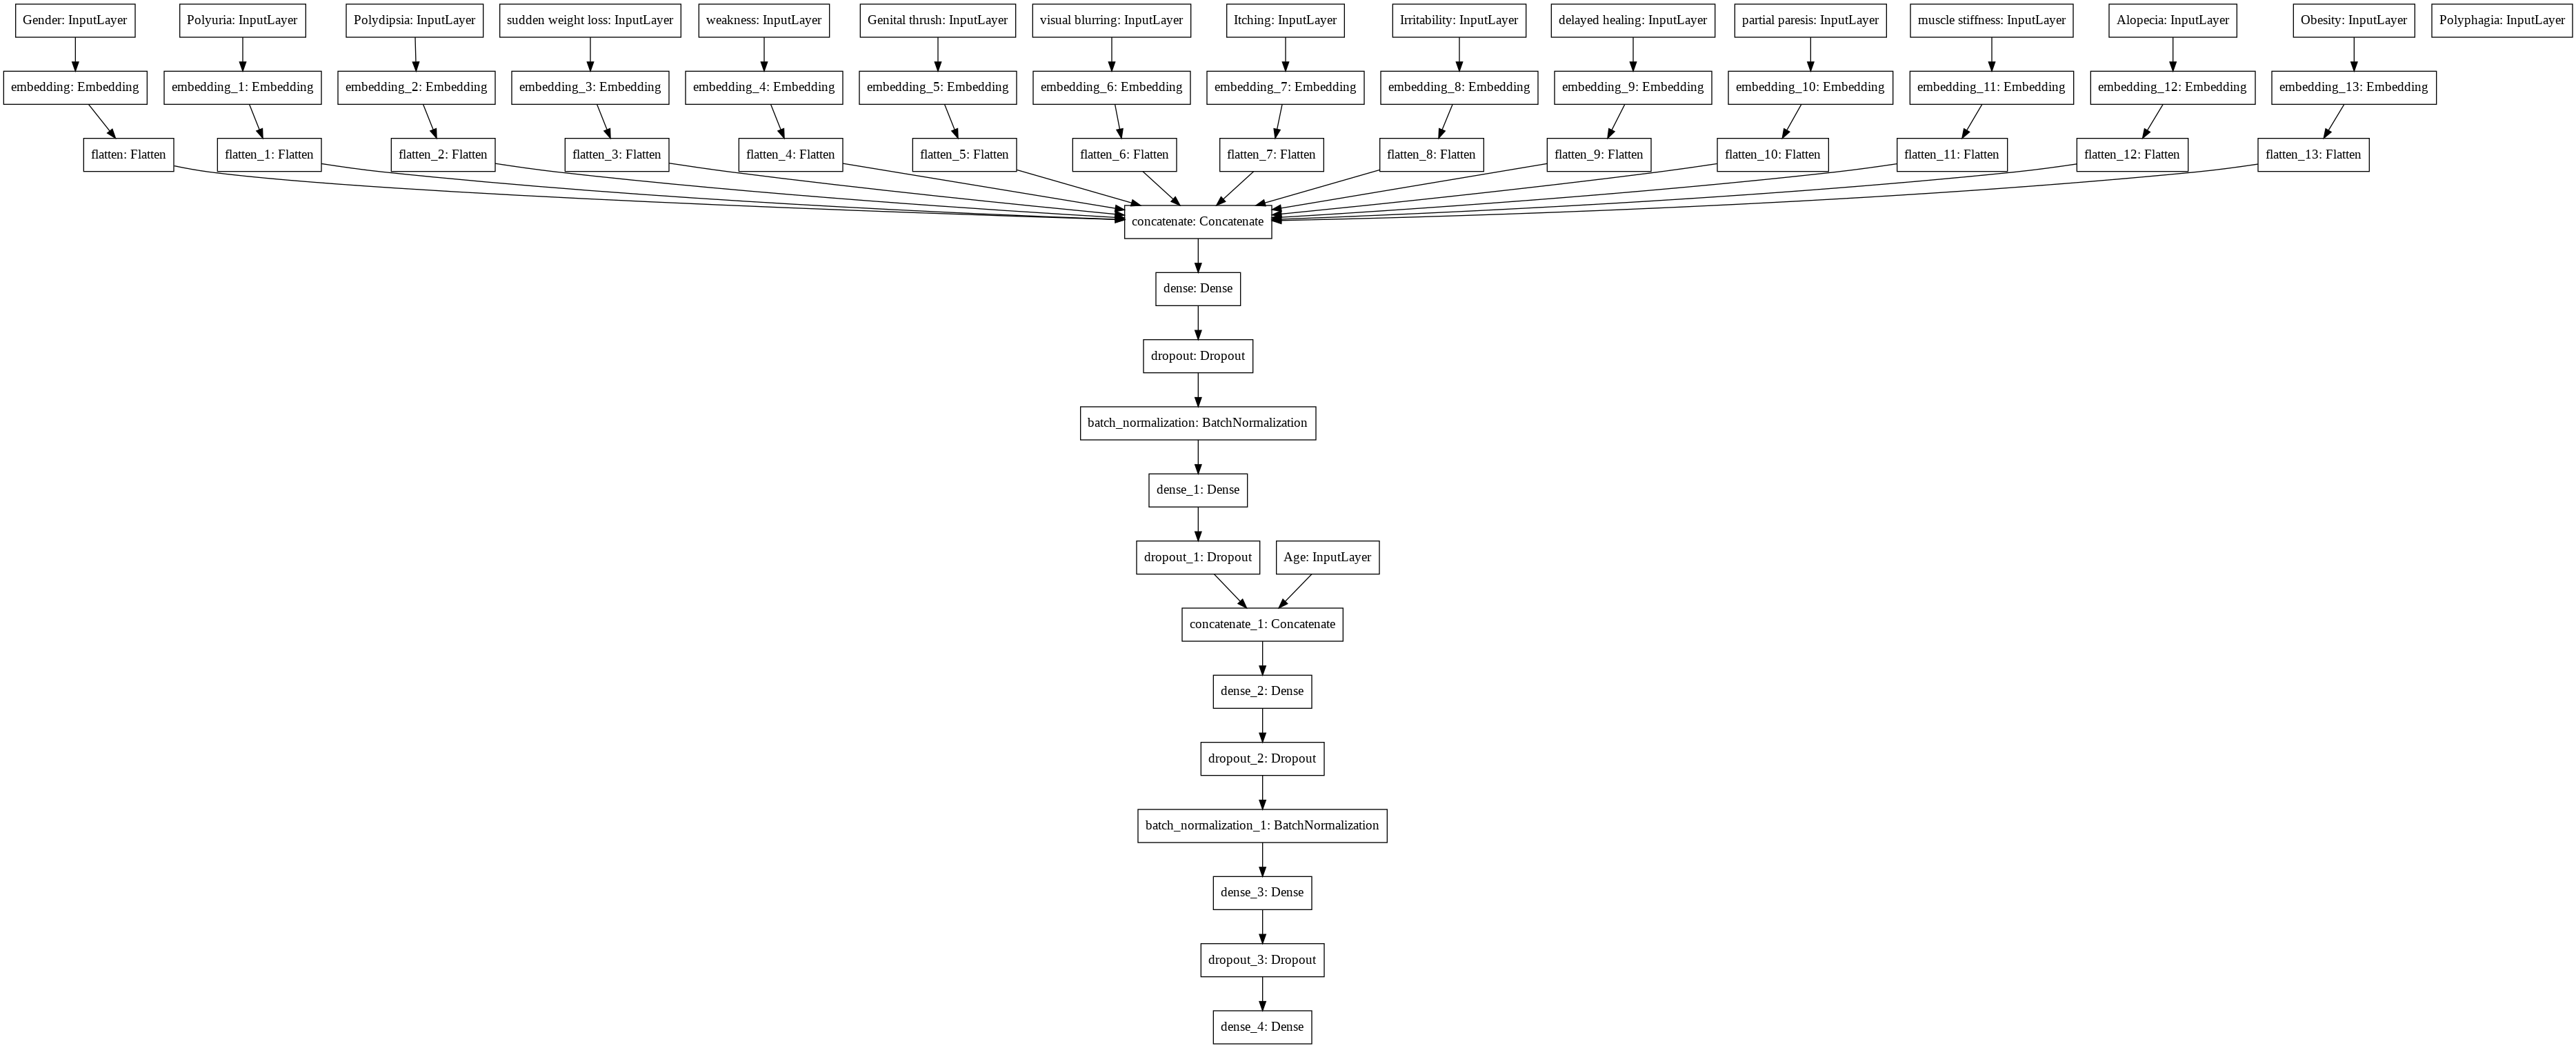

In [ ]:
import tensorflow as tf

tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)


In [ ]:
while 1:
  ads=1

In [ ]:
model1 = load_model('model.hdf5', custom_objects={ 'f1_m': f1_m,'precision_m':precision_m,'recall_m':recall_m,'specificity':specificity})

In [ ]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Gender (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Polyuria (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
Polydipsia (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
sudden weight loss (InputLayer) [(None, 1)]          0                                            
____________________________________________________________________________________________